In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from scaled_dataloader import load_train, load_val
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


In [ ]:
N_FEATURES = 5  # LAT, LON, SOG, COG_sin, COG_cos
LOOKBACK = 30
N_PREDICT = 10

class Seq2SeqLSTM(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Encoder LSTM
        self.encoder_lstm = nn.LSTM(
            input_size=N_FEATURES,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        
        # Decoder LSTM
        self.decoder_lstm = nn.LSTM(
            input_size=N_FEATURES,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        
        # Linear output
        self.l_out = nn.Linear(hidden_size, N_FEATURES)
    
    def forward(self, x):        
        # -------- Encoder --------
        _, (h, c) = self.encoder_lstm(x)  # h,c shape: (num_layers, batch, hidden)
        
        # -------- Decoder --------
        # Start with last input timestep as first decoder input
        decoder_input = x[:, -1, :].unsqueeze(1)  # shape: (batch, 1, N_FEATURES)
        outputs = []
        
        for _ in range(N_PREDICT):
            out, (h, c) = self.decoder_lstm(decoder_input, (h, c))
            y = self.l_out(out)  # shape: (batch, 1, N_FEATURES)
            outputs.append(y)
            
            # Feed the prediction back as next input (autoregressive)
            decoder_input = y
        
        # Concatenate all predictions along time dimension
        outputs = torch.cat(outputs, dim=1)  # shape: (batch, N_PREDICT, N_FEATURES)
        return outputs

In [24]:
# Hyperparameters
num_epochs = 5
lr = 1e-3
hidden_size = 64
num_layers = 1

In [25]:
batch_size = 2048

#load data
train_ds, scaler = load_train()
val_ds = load_val(scaler)
train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=4, shuffle=False)


Loading TRAIN...


100%|██████████| 59518/59518 [00:33<00:00, 1794.06it/s]


Loading VAL...


100%|██████████| 12847/12847 [00:05<00:00, 2461.47it/s]


In [20]:
net = Seq2SeqLSTM(hidden_size=hidden_size, num_layers=num_layers).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

# track loss
training_loss, validation_loss = [], []
best_val_loss = float("inf")

for epoch in range(1, num_epochs + 1):
    # training
    net.train()
    epoch_train_loss = 0.0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch} Training", leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = net(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * x.size(0)
    epoch_train_loss /= len(train_loader.dataset)

    # validation
    net.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=f"Epoch {epoch} Validation", leave=False):
            x, y = x.to(device), y.to(device)
            y_pred = net(x)
            loss = criterion(y_pred, y)
            epoch_val_loss += loss.item() * x.size(0)
    epoch_val_loss /= len(val_loader.dataset)
    
    # save best model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(net.state_dict(), "best_lstm_model.pt")
    
    # track
    training_loss.append(epoch_train_loss)
    validation_loss.append(epoch_val_loss)

    #print loss every epoch
    print(f"Epoch {epoch}/{num_epochs}, Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

Epoch 1/5, Training Loss: 0.1658, Validation Loss: 0.1385


Epoch 2/5, Training Loss: 0.1389, Validation Loss: 0.1321


Epoch 3/5, Training Loss: 0.1343, Validation Loss: 0.1286


Epoch 4/5, Training Loss: 0.1314, Validation Loss: 0.1268


Epoch 5/5, Training Loss: 0.1294, Validation Loss: 0.1254


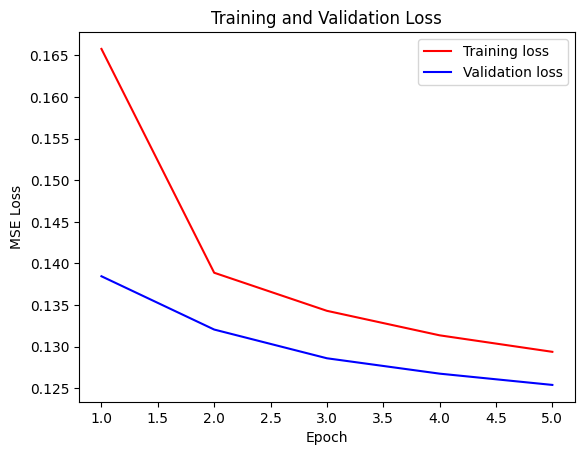

In [21]:
# plot training and validation loss
plt.figure()
plt.plot(range(1, num_epochs + 1), training_loss, 'r', label='Training loss')
plt.plot(range(1, num_epochs + 1), validation_loss, 'b', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

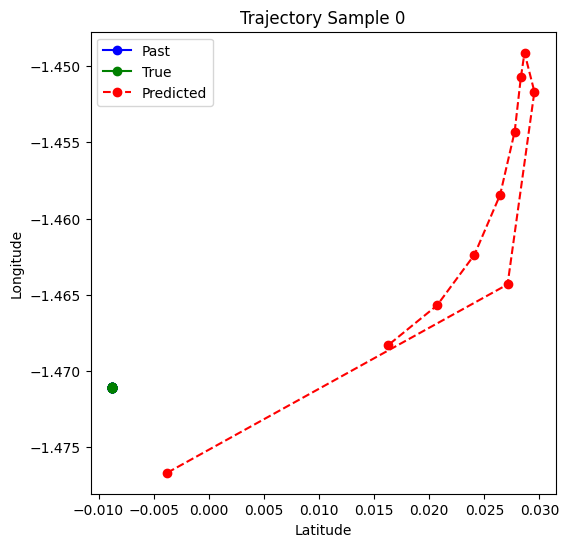

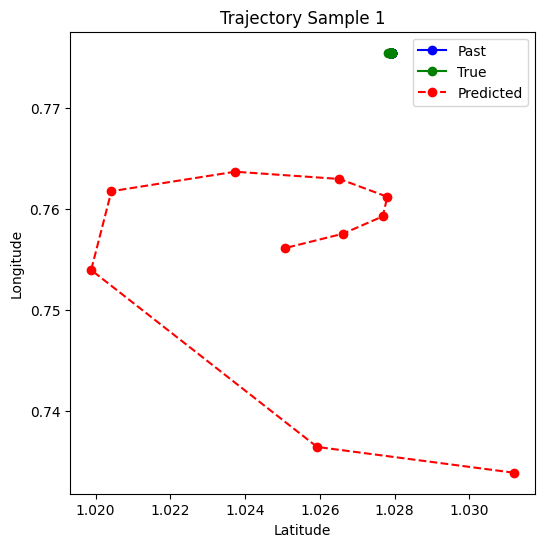

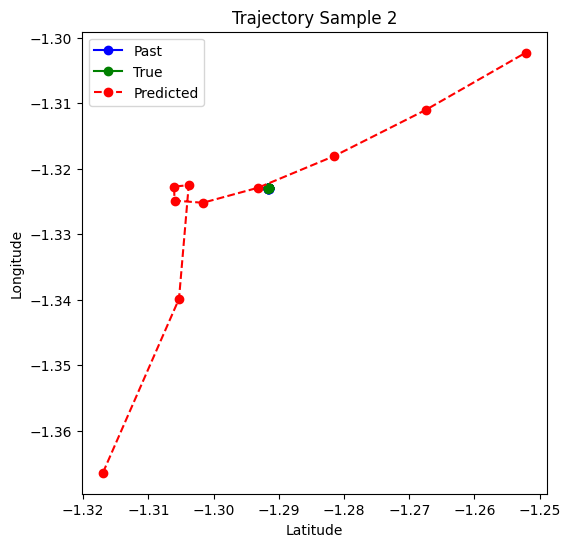

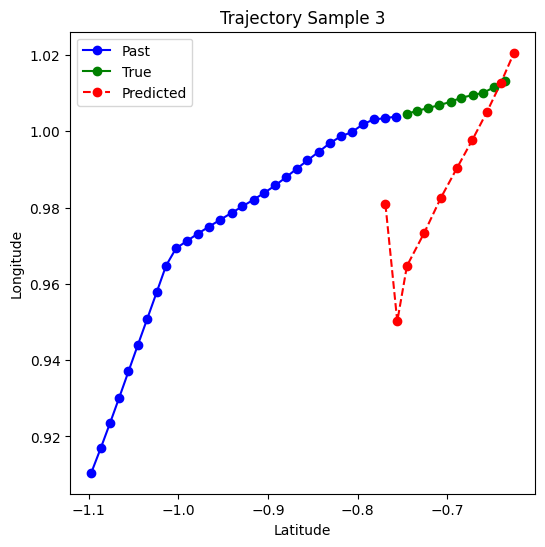

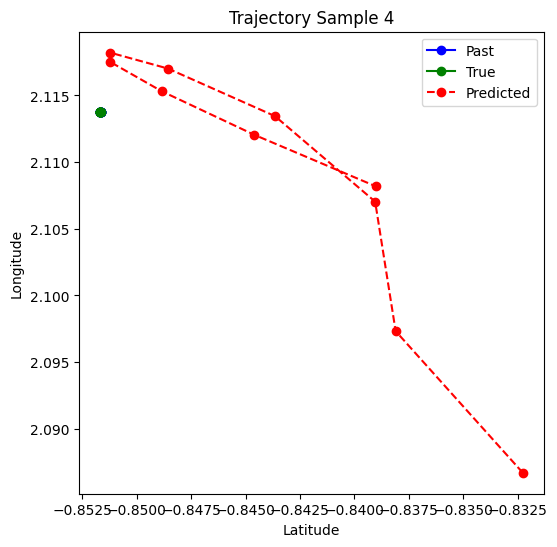

In [22]:
from plot_trajectory import plot_paths
num_samples_to_plot = 5

# load model
net = Seq2SeqLSTM(hidden_size=hidden_size, num_layers=num_layers).to(device)
net.load_state_dict(torch.load("best_lstm_model.pt"))
net.eval()

# plot
for idx, (x, y) in enumerate(val_loader):
    if idx >= num_samples_to_plot:
        break
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        y_pred = net(x)
    
    # pick the first element in the batch
    x_np = x[0].cpu().numpy()             # (30,5)
    y_np = y[0].cpu().numpy()             # (10,5)
    y_pred_np = y_pred[0].cpu().numpy().reshape(10, 5)  # reshape flat 50 -> (10,5)

    plot_paths(x_np, y_np, y_pred_np, idx)
